In [ ]:
%matplotlib inline

In [1]:
import os
import numpy as np
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order
from statsmodels.iolib.table import SimpleTable
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from PIL import Image, ImageDraw, ImageFont
from scipy.stats import chi2_contingency

In [2]:
# Set directory path to current directory
dir_path = os.path.abspath('')
dat = os.path.join(dir_path, 'control_variables.xlsx')

In [3]:
df = pd.read_excel(dat, index_col=0, sheet_name="data")
df = pd.DataFrame(df)

In [4]:
# Define country lists based on income level
low_income = ['Burkina Faso', 
              'Burundi', 
              'Central African Republic',
              'Chad',
              'Ethiopia', 
              'Gambia, The',
              'Guinea',
              'Madagascar',
              'Malawi',
              'Mali',
              'Mozambique',
              'Niger',
              'Rwanda',
              'Sudan',
              'Togo',
              'Uganda']

lower_middle = ['Angola',
                'Benin',
                'Cabo Verde',
                'Cameroon',
                'Comoros',
                'Cote d\'Ivoire',
                'Eswatini',
                'Ghana',
                'Kenya',
                'Lesotho',
                'Mauritania',
                'Nigeria',
                'Sao Tome and Principe',
                'Senegal',
                'Tanzania',
                'Zambia',
                'Zimbabwe']

higher_middle = ['Botswana',
                 'Gabon',
                 'Mauritius',
                 'Namibia',
                 'South Africa',
                 'Seychelles']

In [7]:
df = df.reset_index()

In [11]:
df['eElec_abs'] = df.groupby('country')['elec_rate'].pct_change()
df['eElec_abs'].fillna(0, inplace=True)


In [12]:
# Write the data into an excel sheet
with pd.ExcelWriter(dat,
                    engine='openpyxl',
                    mode='a',
                    if_sheet_exists="new"
) as writer:
    writer.book = openpyxl.load_workbook(dat)
    df['eElec_abs'].to_excel(writer, sheet_name='elec_trans')    

In [6]:
# Gourp countries by income levels
lowIncome_df=df[df['country'].isin(low_income)]
lowerMiddle_df=df[df['country'].isin(lower_middle)]
highIncome_df=df[df['country'].isin(higher_middle)]

In [7]:
# Computing log variables and store them into dataframes
df['energy total'] = df['distribution cumulative']+df['nrgen cumulative']+df['policy cumulative']+df['rgen cumulative']
df['log energy'] = np.log(df['energy total']+1)
df['aid']=df['energy aid']/1000000
df['log energy cum'] = np.log(df.groupby('country')['energy aid'].cumsum()/1000000+1)
df['log policy'] = np.log(df['policy cumulative']+1)
df['log rgen'] = np.log(df['rgen cumulative']+1)
df['log nrgen'] = np.log(df['nrgen cumulative']+1)
df['log distribution'] = np.log(df['distribution cumulative']+1)
df['log govern'] = np.log(df['governance']+1)
df['log elec'] = np.log(df['elec_rate']+1)
df['log delec'] = np.log(df['dElec']+1)
df['log gdp'] = np.log(df['gdp']+1)
# df['log cpi'] = np.log(df['dCPI']+1)
df['log cpi'] = np.log(df['cpi-2010']+1)
df['log trade'] = np.log(df['trade']+1)

In [8]:
# Put useful variables into one single datadrame
df_1 = df[['log distribution',
           'log nrgen',
           'log policy',
           'log rgen',
           'log cpi',
           'log trade',
           'log energy'                                                   
           ]]

# Write the data into an excel sheet
# with pd.ExcelWriter(dat,
#                     engine='openpyxl',
#                     mode='a',
#                     if_sheet_exists="new"
# ) as writer:
#     writer.book = openpyxl.load_workbook(dat)
#     lowIncome_df.to_excel(writer, sheet_name='low_income')
#     lowerMiddle_df.to_excel(writer, sheet_name='middle_income')
#     highIncome_df.to_excel(writer, sheet_name='high_income')
#     # df['log gdp'].to_excel(writer, sheet_name='log gdp')

In [11]:
def cramers_corrected_sta(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)/(n-1)))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = r - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1),(rcorr-1)))

In [12]:
cramers_corrected_sta(df_1)

ValueError: All values in `observed` must be nonnegative.

In [ ]:
# Sub-Saharan African countries' panel data analysis elec ~ energy, cpi, trade
sel_res = ardl_select_order(df['log elec'], 
                            2,
                            df[['log energy', 
                                'log cpi',
                                'log trade',
                                'log gdp'
                               ]],
                            2, ic='aic', trend='c'
                            )
res = sel_res.model.fit()
print(f'Panel ARDL analysis on sub-Saharan African countries for aid, CPI, trade and GDP: \n f-test results for the model is: \n {res.summary()}')

In [ ]:
# Panel ARDL analysis for four energy sub sectors
sel_res = ardl_select_order(highIncome_df['log elec'], 
                            2,
                            highIncome_df[['log distribution',
                                           'log nrgen',
                                           'log policy',
                                           'log rgen'                      
                                           ]], 
                            2, ic='aic', trend='c'
                            )
    
res = sel_res.model.fit()
print(f'panel ardl for energy sub-sectors for middle and high income countries (log) \n f-test results for the model is: \n {res.summary()}')

In [ ]:
# Make two dataframe for cointegration tests

ic_df = df[[
           'log cpi',
           'log trade',
           'log energy'                                                   
           ]]

aid_df = df[['log distribution',
           'log nrgen',
           'log policy',
           'log rgen',                                                 
           ]]

 'cvm',
 'cvt',
 'eig',
 'evec',
 'ind',
 'lr1',
 'lr2',
 'max_eig_stat',
 'max_eig_stat_crit_vals',
 'meth',
 'r0t',
 'rkt',
 'trace_stat',
 'trace_stat_crit_vals']

In [ ]:
# Johansen cointegration test
print(f'The trace stat critical values for IC are: \n{coint_johansen(ic_df, 0, 2).trace_stat_crit_vals}')
print(f'The max eigen stats critical values for IC are: \n{coint_johansen(ic_df, 0, 2).max_eig_stat_crit_vals}')

print(f'The trace stat critical values for aid are: \n{coint_johansen(aid_df, 0, 2).trace_stat_crit_vals}')
print(f'The max eigen stats critical values for aid are: \n{coint_johansen(aid_df, 0, 2).max_eig_stat_crit_vals}')


In [8]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [12]:
print('log elec')
print(adf_test(df['log elec']))

print(f'The ADF test for log trade is:')
print(adf_test(df['log trade']))

print('CPI')
print(adf_test(df['log cpi']))

print('Energy aid')
print(adf_test(df['log energy']))

print('log GDP')
print(adf_test(df['log gdp']))

print('log govern')
print(adf_test(df['log govern']))

print('dGDP')
print(adf_test(df['dGDP']))

# print('distribution')
# print(adf_test(df['log distribution']))
# print('non renewable')
# print(adf_test(df['log nrgen']))
# print('policy')
# print(adf_test(df['log policy']))
# print('renewable')
# print(adf_test(df['log rgen']))

log elec
Results of Dickey-Fuller Test:
Test Statistic                  -5.337665
p-value                          0.000005
#Lags Used                       3.000000
Number of Observations Used    698.000000
Critical Value (1%)             -3.439753
Critical Value (5%)             -2.865690
Critical Value (10%)            -2.568980
dtype: float64
None
The ADF test for log trade is:
Results of Dickey-Fuller Test:
Test Statistic                  -4.834607
p-value                          0.000047
#Lags Used                      18.000000
Number of Observations Used    683.000000
Critical Value (1%)             -3.439961
Critical Value (5%)             -2.865781
Critical Value (10%)            -2.569028
dtype: float64
None
CPI
Results of Dickey-Fuller Test:
Test Statistic                -7.326200e+00
p-value                        1.159317e-10
#Lags Used                     1.800000e+01
Number of Observations Used    6.830000e+02
Critical Value (1%)           -3.439961e+00
Critical Value 

In [11]:
print(adf_test(df['elec_rate']))

Results of Dickey-Fuller Test:
Test Statistic                  -5.194412
p-value                          0.000009
#Lags Used                       0.000000
Number of Observations Used    701.000000
Critical Value (1%)             -3.439713
Critical Value (5%)             -2.865672
Critical Value (10%)            -2.568970
dtype: float64
None


In [ ]:
print('CPI')
print(adf_test(df['dGDP']))
print(adf_test(df['log gdp']))

In [244]:
# Define the depedent variable
pooled_y= df['log elec']

# Define the independent variables used in three different models
pooled_X0=df['log energy']

pooled_X1=df[['log energy',
              'log cpi',
              'log trade',
              'log govern'                                                            
              ]]

pooled_X3=df[['log energy',
              'log gdp',
              'dGDP'                                                          
              ]]

pooled_X2=df[['log energy',
              'log cpi',
              'log trade',
              'log govern',
              'log gdp',   
              'dGDP'                                                         
              ]]

# Add constant for three models
pooled_X0 = sm.add_constant(pooled_X0)
pooled_X1 = sm.add_constant(pooled_X1)
pooled_X2 = sm.add_constant(pooled_X2)
pooled_X3 = sm.add_constant(pooled_X3)

pooled_olsr_model0 = sm.OLS(endog=pooled_y, exog=pooled_X0)
pooled_olsr_model1 = sm.OLS(endog=pooled_y, exog=pooled_X1)
pooled_olsr_model2 = sm.OLS(endog=pooled_y, exog=pooled_X2)
pooled_olsr_model3 = sm.OLS(endog=pooled_y, exog=pooled_X3)

pooled_olsr_model_results0 = pooled_olsr_model0.fit()
pooled_olsr_model_results1 = pooled_olsr_model1.fit()
pooled_olsr_model_results2 = pooled_olsr_model2.fit()
pooled_olsr_model_results3 = pooled_olsr_model3.fit()

# Print out the results in summary columns    
results = summary_col([pooled_olsr_model_results0, pooled_olsr_model_results1, pooled_olsr_model_results2, pooled_olsr_model_results3],
                       stars=True,float_format='%0.8f',
                       model_names=['Model 1', 'Model 2', 'Model 3', 'Model 4'],
                       info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                                  'R2':lambda x: "{:0.2f}".format(x.rsquared),
                                  'R2-adjusted': lambda x: "{:0.4f}".format(x.rsquared_adj)})
print(results) 

TypeError: unsupported format string passed to RegressionResultsWrapper.__format__

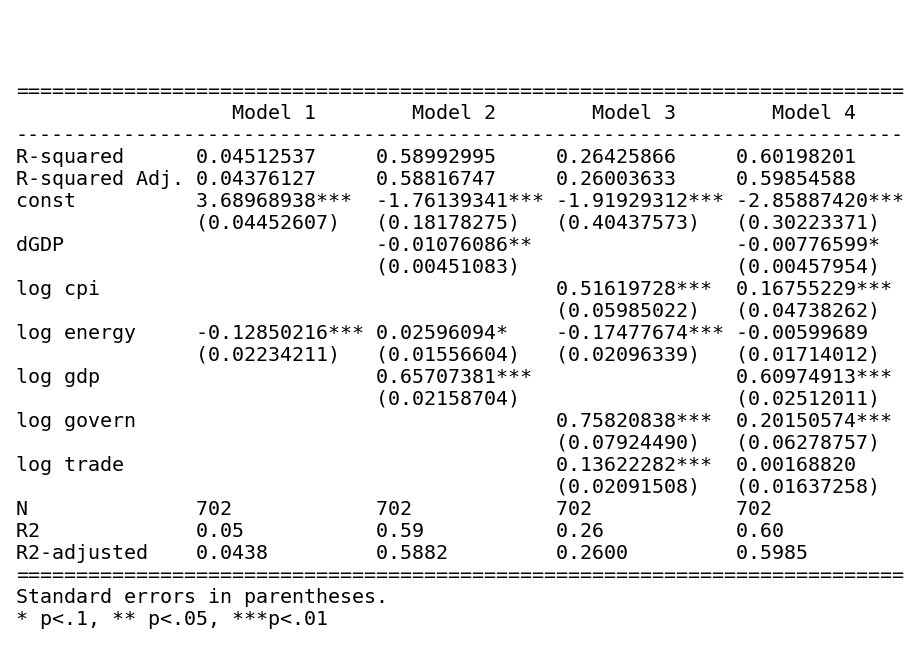

In [243]:
plt.rc('figure', figsize=(14, 10))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(results), {'fontsize': 20}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('output.png')

In [ ]:
coeffients1 = []
coeffients2 = []
headers1 = []
headers2 = []
countries1 = []
countries2 = []
confidence1 = []
confidence2 = []

In [ ]:
# Putting the coefficients into a table
tbl1 = SimpleTable(coeffients1, headers1, countries1,
                  data_fmts=["%3.2f","%d"])
tbl2 = SimpleTable(coeffients2, headers2, countries2,
                  data_fmts=["%3.2f","%d"])

# Turning the table into a dataframe
tbl_df1 = pd.DataFrame(tbl1, columns=["Const", "Elec l0", "Elec l1", "Elec l2", "Aid l0", "Aid l1", "Aid l2", "CPI l0", "CPI l1", "CPI l2", "Trade l0", "Trade l1", "Trade l2"])
tbl_df2 = pd.DataFrame(tbl2, columns=["Const", "Elec l0", "Elec l1", "Elec l2", "Distribution l0", "Distribution l1", "Distribution l2", "Nrgen l0", "Nrgen l1", "Nrgen l2", "Policy l0", "Policy l1", "Policy l2", "Rgen l0", "Rgen l1", "Rgen l2"])

In [ ]:
output = os.path.join(dir_path, 'outputs/ardl_output.xlsx')

# Write the data into an excel sheet
with pd.ExcelWriter(output,
                    engine='openpyxl',
                    mode='a',
                    if_sheet_exists="new"
) as writer:
    writer.book = openpyxl.load_workbook(output)
    tbl_df1.to_excel(writer, sheet_name='coef')

In [ ]:
# Model 1 electricity against aid, cpi, and trade
for name, group in df.groupby('country'):
    sel_res = ardl_select_order(group['log elec'], 
                                2,
                                group[['log energy', 
                                       'log cpi',
                                       'log trade'
                                       ]],
                                2, ic='aic', trend='c'
                                )
    res = sel_res.model.fit()
    print(res.summary())
# #     coeffients1.append(res.params)
# #     confidence1.append(res.pvalues)

# # Model 2 electricity against four sub-sectors
# for name, group in df.groupby('country'):
#     sel_res = ardl_select_order(group['log elec'], 
#                                 2,
#                                 group[['log distribution',
#                                        'log nrgen',
#                                        'log policy',
#                                        'log rgen'                                                   
#                                        ]], 
#                                 2, ic='aic', trend='c'
#                                 )
    
#     res = sel_res.model.fit()
    
#     coeffients2.append(res.params)
#     confidence2.append(res.pvalues)

/opt/anaconda3/envs/MyPythonProject/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/MyPythonProject/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


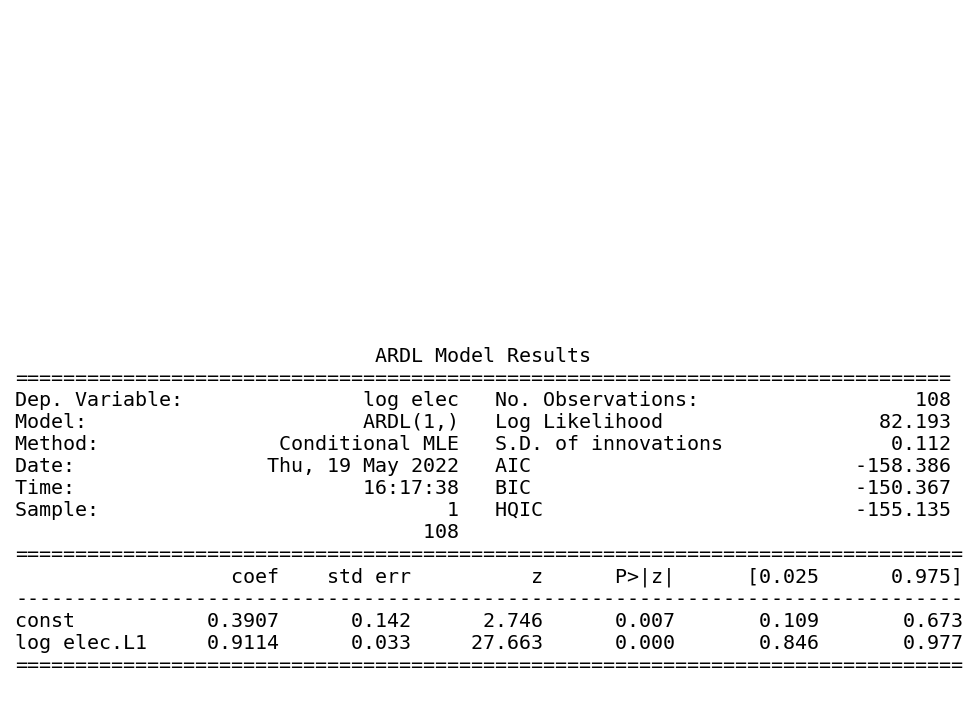

In [249]:
sel_res = ardl_select_order(highIncome_df['log elec'], 
                                2,
                                highIncome_df[['log distribution',
                                       'log nrgen',
                                       'log policy',
                                       'log rgen'                                                   
                                       ]], 
                                2, ic='aic', trend='c'
                                )
    
res = sel_res.model.fit()
results=res.summary() 

plt.rc('figure', figsize=(14, 10))
#plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 12}) old approach
plt.text(0.01, 0.05, str(results), {'fontsize': 20}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.tight_layout()
plt.savefig('sector aid high income.png')


In [245]:
# Model 1 electricity against aid, cpi, and trade
sel_res = ardl_select_order(df['log elec'], 
                            2,
                            df[['log energy', 
                                   'log cpi',
                                   'log trade',
                                   'log gdp'
                                   # 'log govern'
                                   ]],
                            2, ic='aic', trend='c'
                            )
res = sel_res.model.fit()
print(f'panel ardl for aid, cpi and trade {res.summary()}')

sel_res1 = ardl_select_order(df['log elec'], 
                                2,
                                df[['Energy distribution',
                                       'Energy generation, non-renewable sources',
                                       'Energy Policy',
                                       'Energy generation, renewable sources'                                                   
                                       ]], 
                                2, ic='aic', trend='c'
                                )
    
res1 = sel_res1.model.fit()
print(f'panel ardl for sector energy aid {res1.summary()}')

sel_res2 = ardl_select_order(df['log elec'], 
                                2,
                                df[['log distribution',
                                       'log nrgen',
                                       'log policy',
                                       'log rgen'                                                   
                                       ]], 
                                2, ic='aic', trend='c'
                                )
    
res2 = sel_res2.model.fit()
print(f'panel ardl for log sector energy aid {res2.summary()}')
print(f'p value for model 3 is {res2.pvalues}')


# Model 2 electricity against four sub-sectors

# coef = []
# signif = []

# for name, group in df.groupby('country'):
#     sel_res = ardl_select_order(group['log elec'], 
#                                 2,
#                                 group[['Energy distribution',
#                                        'Energy generation, non-renewable sources',
#                                        'Energy Policy',
#                                        'Energy generation, renewable sources'                                                   
#                                        ]], 
#                                 2, ic='aic', trend='c'
#                                 )
    
#     res = sel_res.model.fit()
#     print(res.summary())
#     coef.append(res.params)
#     signif.append(res.pvalues)
    
# output = os.path.join(dir_path, 'outputs/ardl_output.xlsx')
# coef_df = pd.DataFrame(coef)
# sig_df = pd.DataFrame(signif)

# # Write the data into an excel sheet
# with pd.ExcelWriter(output,
#                     engine='openpyxl',
#                     mode='a',
#                     if_sheet_exists="new"
# ) as writer:
#     writer.book = openpyxl.load_workbook(output)
#     coef_df.to_excel(writer, sheet_name='coef-aid4-noncum')
#     sig_df.to_excel(writer, sheet_name='p-aid4-noncum')
    

panel ardl for aid, cpi and trade                               ARDL Model Results                              
Dep. Variable:               log elec   No. Observations:                  702
Model:               ARDL(2, 1, 0, 2)   Log Likelihood                  90.709
Method:               Conditional MLE   S.D. of innovations              0.213
Date:                Thu, 19 May 2022   AIC                           -161.419
Time:                        16:00:39   BIC                           -115.908
Sample:                             2   HQIC                          -143.826
                                  702                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.2578      0.122     -2.106      0.036      -0.498      -0.018
log elec.L1      0.7623      0.039     19.629      0.000       0.686       0.839
log elec.L

In [ ]:
output = os.path.join(dir_path, 'outputs/ardl_output.xlsx')
c1_df = pd.DataFrame(coeffients1)
c2_df = pd.DataFrame(coeffients2)
p1_df = pd.DataFrame(confidence1)
p2_df = pd.DataFrame(confidence2)

# Write the data into an excel sheet
with pd.ExcelWriter(output,
                    engine='openpyxl',
                    mode='a',
                    if_sheet_exists="new"
) as writer:
    writer.book = openpyxl.load_workbook(output)
    c1_df.to_excel(writer, sheet_name='coefficient-aid-c')
    c2_df.to_excel(writer, sheet_name='coefficient-4sec')
    p1_df.to_excel(writer, sheet_name='p-aid-c')
    p2_df.to_excel(writer, sheet_name='p-4sec')

In [ ]:
for name, group in df.groupby('country'):
    sel_res = ardl_select_order(group['log elec'], 
                                2,
                                group[['log energy', 
                                       'log cpi',
                                       'log trade',
#                                        'log gov'
                                      ]],
                                2, ic='aic', trend='c'
                                )
    res = sel_res.model.fit()
    
    print(dir(res))

In [ ]:
for name, group in df.groupby('country'):
    sel_res = ardl_select_order(group['log elec'], 
                                2,
                                group[['log energy', 
                                       'log cpi',
                                       'log trade',
                                      ]],
                                2, ic='aic', trend='c'
                                )
    res = sel_res.model.fit()
    print(res.summary())
    
#     results = summary_col([res],stars=True,float_format='%0.8f',
#                        model_names=['Model 1'],
#                        info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
#                                   'R2':lambda x: "{:.2f}".format(x.rsquared)})
#     print(f'the results for {name} is {results}')
    
    print(f"The optimal order for {name} is: {sel_res.model.ardl_order}")

In [ ]:
for name, group in df.groupby('country'):
    sel_res = ardl_select_order(group['dElec'], 
                                2,
                                group[['distribution cumulative',
                                        'nrgen cumulative',
                                        'policy cumulative',
                                        'rgen cumulative',              
                                        ]], 
                                2, ic='aic', trend='c'
    
                                )
#     print(name)
    res = sel_res.model.fit()
    print(res.summary())
    
#     results = summary_col([res],stars=True,float_format='%0.8f',
#                        model_names=['Model 1'],
#                        info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
#                                   'R2':lambda x: "{:.2f}".format(x.rsquared)})
#     print(f'the results for {name} is {results}')
    
    print(f"The optimal order for {name} is: {sel_res.model.ardl_order}")

    
 